In [16]:
import sqlite3
import csv
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np

db_path = "sir.db"
covid_paths = "../COVID-19/csse_covid_19_data/csse_covid_19_time_series/time_series_19-covid-"

conn = sqlite3.connect(db_path)
c = conn.cursor()
c2 = conn.cursor()

c.execute('PRAGMA foreign_keys = ON')
c2.execute('PRAGMA foreign_keys = ON')

In [2]:
# Create tables
create_cities_table_command = '''
CREATE TABLE IF NOT EXISTS cities (
    country VARCHAR(255),    
    city VARCHAR(255),
    location VARCHAR(255) NOT NULL,
    date DATE NOT NULL,
    susceptible INT,
    infected INT,
    delta_infected INT,
    recovered INT,
    PRIMARY KEY(date, location)
    );
'''
c.execute(create_cities_table_command)
conn.commit()

In [4]:
confirmed_file = covid_paths + 'Confirmed.csv'
deaths_file = covid_paths + 'Deaths.csv'
recovered_file = covid_paths + 'Recovered.csv'
df_confirmed = pd.read_csv(confirmed_file)
df_deaths = pd.read_csv(deaths_file)
df_recovered = pd.read_csv(recovered_file)

print(df_confirmed.head())

  Province/State  Country/Region      Lat      Long  1/22/20  1/23/20  \
0          Anhui  Mainland China  31.8257  117.2264        1        9   
1        Beijing  Mainland China  40.1824  116.4142       14       22   
2      Chongqing  Mainland China  30.0572  107.8740        6        9   
3         Fujian  Mainland China  26.0789  117.9874        1        5   
4          Gansu  Mainland China  36.0611  103.8343        0        2   

   1/24/20  1/25/20  1/26/20  1/27/20  ...  2/26/20  2/27/20  2/28/20  \
0       15       39       60       70  ...      989      989      990   
1       36       41       68       80  ...      400      410      410   
2       27       57       75      110  ...      576      576      576   
3       10       18       35       59  ...      294      296      296   
4        2        4        7       14  ...       91       91       91   

   2/29/20  3/1/20  3/2/20  3/3/20  3/4/20  3/5/20  3/6/20  
0      990     990     990     990     990     990     990  


In [11]:
dates = []
for col in df_confirmed.columns:
    pattern = re.compile('^\d+/\d+/\d+')
    if pattern.match(col):
        dates.append(col)

for row in df_confirmed.iterrows():
    city = row[1]['Province/State']
    country = row[1]['Country/Region']
    location = country
    if (isinstance(city, str)):
         location = location + ', ' + city

    prev_infected = -1
    prev_prev_infected = -1
    prev_date = ""
    for date in dates:
        split_date = date.split('/')
        month = split_date[0].zfill(2)
        day = split_date[1].zfill(2)
        year = '20' + split_date[2]
        date_str = year + '-' + month + '-' + day
        
        cur_infected = row[1][date]
        
        if prev_infected == -1:
            prev_infected = cur_infected
            prev_date = date_str
            continue
            
        if prev_prev_infected == -1:
            prev_prev_infected = prev_infected
            prev_infected = cur_infected
            prev_date = date_str
            continue
        
        delta_infected = (cur_infected - prev_prev_infected) / 2
        
        
        c.execute('UPDATE cities SET delta_infected="'+str(cur_infected - prev_infected)+'" WHERE location="'+location+'" AND date="'+date_str+'"')
        c.execute('UPDATE cities SET delta_infected="'+str(delta_infected)+'" WHERE location="'+location+'" AND date="'+prev_date+'"')
        
        prev_prev_infected = prev_infected
        prev_infected = cur_infected
        prev_date = date_str
        #c.execute(
        #'''INSERT INTO cities VALUES (?, ?, ?, ?, ?, ?, ?, ?);''', 
        #(country, city, location, date_str, None, cur_infected, delta_infected, None))

conn.commit()
        

In [9]:
for row in df_deaths.iterrows():
    city = row[1]['Province/State']
    country = row[1]['Country/Region']
    location = country
    if (isinstance(city, str)):
         location = location + ', ' + city
    
    for date in dates:
        split_date = date.split('/')
        month = split_date[0].zfill(2)
        day = split_date[1].zfill(2)
        year = '20' + split_date[2]
        date_str = year + '-' + month + '-' + day
        
        recovered = row[1][date]
        
        c.execute('UPDATE cities SET recovered="'+str(recovered)+'" WHERE location="'+location+'" AND date="'+date_str+'";')

conn.commit()

In [21]:
for row in df_recovered.iterrows():
    city = row[1]['Province/State']
    country = row[1]['Country/Region']
    location = country
    if (isinstance(city, str)):
         location = location + ', ' + city
    
    
    for date in dates:
        split_date = date.split('/')
        month = split_date[0].zfill(2)
        day = split_date[1].zfill(2)
        year = '20' + split_date[2]
        date_str = year + '-' + month + '-' + day
        
        c.execute('SELECT recovered FROM cities where location="'+location+'" AND date="'+date_str+'" LIMIT 1;')
        
        cur_recovered = 0
        
        for q in c:
            cur_recovered = q[0]
        cur_recovered += row[1][date]
        
        c.execute('UPDATE cities SET recovered="'+str(cur_recovered)+'" WHERE location="'+location+'" AND date="'+date_str+'";')

conn.commit()

In [14]:
c.execute('''SELECT location, date, infected, recovered FROM cities''')

for row in c:
    location = row[0]
    date = row[1]
    infected = row[2]
    recovered = row[3]
    
    updated_infected = infected - recovered
    c2.execute('UPDATE cities SET infected="'+str(updated_infected)+'" WHERE location ="'+location+'" AND date="'+date+'"')
    
conn.commit()

In [100]:
conn_population = sqlite3.connect('population.db')
pop_c = conn_population.cursor()

In [45]:
pop_c.execute('SELECT province, population_2018 FROM china_provinces;')
for row in pop_c:
    province = row[0]
    population = row[1]
    c.execute('SELECT date, infected, recovered FROM cities WHERE city="'+province+'"')
    for entry in c:
        date = entry[0]
        infected = entry[1]
        recovered = entry[2]
        susceptible = population - infected - recovered
        c2.execute('UPDATE cities SET susceptible="'+str(susceptible)+'" WHERE city="'+province+'" AND date="'+date+'"')
conn.commit()    

In [ ]:
create_temp_table_command = '''
CREATE TABLE IF NOT EXISTS temp (
    country VARCHAR(255),
    population INT,
    PRIMARY KEY country
    );
'''
pop_c.execute(create_temp_table_command)

In [87]:
pop_c.execute('SELECT abb, population_2020 FROM usa;')
for row in pop_c:
    state = row[0]
    population = row[1]
    c.execute('SELECT date, infected, recovered FROM cities WHERE SUBSTR(city, LENGTH(city) - 1, 2) LIKE "'+state+'";')
    for entry in c:
        
        date = entry[0]
        infected = entry[1]
        recovered = entry[2]
        susceptible = population - infected - recovered
        c2.execute('UPDATE cities SET susceptible="'+str(susceptible)+'" WHERE SUBSTR(city, LENGTH(city) - 1, 2) LIKE "'+state+'" AND date="'+date+'"')
conn.commit()    

In [108]:
pop_c.execute('SELECT * FROM canada;')
for row in pop_c:
    city = ' '+row[0]
    population = row[1]
    length = len(city)
    c.execute('SELECT date, infected, recovered FROM cities WHERE SUBSTR(city, 1, '+str(length)+') LIKE "'+city+'";')
    for entry in c:
        date = entry[0]
        infected = entry[1]
        recovered = entry[2]
        susceptible = population - infected - recovered
        c2.execute('UPDATE cities SET susceptible="'+str(susceptible)+'" WHERE SUBSTR(city, 1, '+str(length)+') LIKE "'+city+'" AND date="'+date+'"')
conn.commit()    

In [76]:
pop_c.execute('SELECT * FROM country_populations;')
for row in pop_c:
    country = row[0]
    population = int(row[1].replace(' ', ''))*1000
    if 'China' in country or country == 'Canada' or country == 'Australia':
        continue
    c.execute('SELECT date, infected, recovered FROM cities WHERE country="'+country+'"')
    for entry in c:
        date = entry[0]
        infected = entry[1]
        recovered = entry[2]
        susceptible = population - infected - recovered
        c2.execute('UPDATE cities SET susceptible="'+str(susceptible)+'" WHERE country="'+country+'" AND date="'+date+'"')
conn.commit()    

Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
Mainland China, Hubei
South Korea
South Korea
South Korea
South Korea
South Korea
South Korea
South Korea
South Korea
Italy
Italy
Italy
Italy
Iran
Iran
Iran
50633


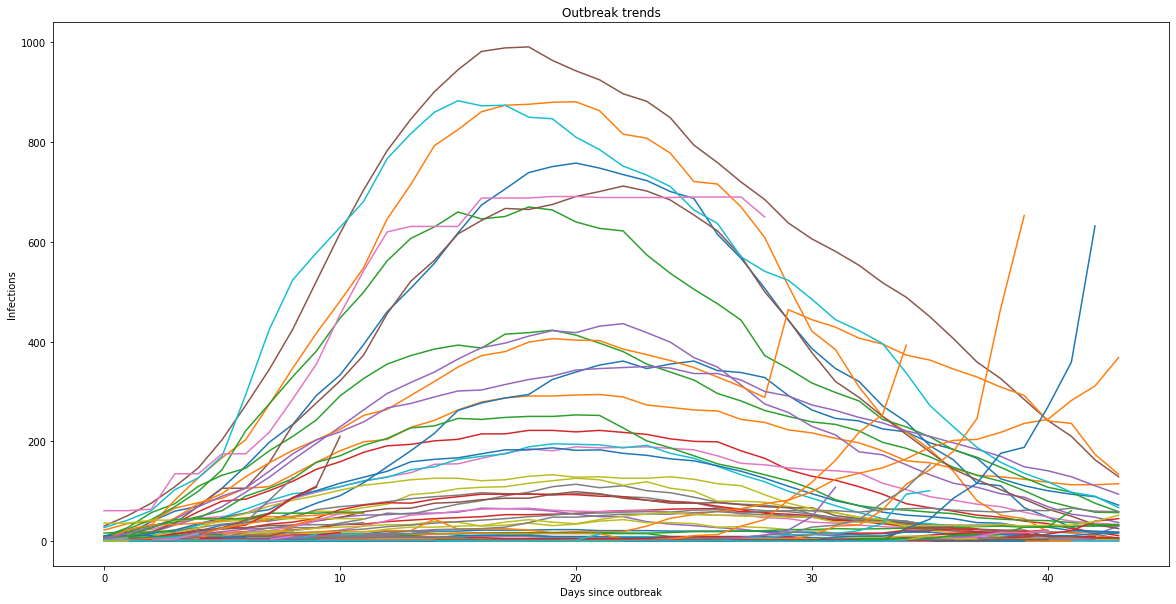

In [85]:
plt.figure(figsize=(20, 10))
plt.title("Outbreak trends")
plt.xlabel("Days since outbreak")
plt.ylabel("Infections")

maxxx = 0

for row in df_recovered.iterrows():
    city = row[1]['Province/State']
    country = row[1]['Country/Region']
    location = country
    if (isinstance(city, str)):
         location = location + ', ' + city
    
    X = []
    Y = []
    start = False
    counter = 0
    include = True
    max_y = 0
    
    c2.execute('SELECT infected FROM cities WHERE location="'+location+'";')
    for entry in c2:
        if entry[0] > 2000:
            print(location)
            include = False
        if entry[0] > 0:
            start = True
        if start != True:
            continue
        X.append(counter)
        counter += 1
        Y.append(entry[0])
        max_y = max(max_y, entry[0])
        maxxx = max(maxxx, entry[0])

        
    # Plot and show
    if include == True:
        plt.plot(X, Y)

print(maxxx)
plt.show()

conn.commit()

In [126]:
c.execute('''SELECT * FROM cities ORDER BY RANDOM() LIMIT 100''')

for row in c:
    c_sample.execute(
    '''INSERT INTO samples VALUES (?, ?, ?, ?, ?, ?, ?, ?);''', 
    (row[0], row[1], row[2], row[3], row[4], row[5], row[6], row[7]))
conn_sample.commit()

In [125]:
# Create tables
create_sample_table_command = '''
CREATE TABLE IF NOT EXISTS samples (
    country VARCHAR(255),    
    city VARCHAR(255),
    location VARCHAR(255) NOT NULL,
    date DATE NOT NULL,
    susceptible INT,
    infected INT,
    delta_infected INT,
    recovered INT,
    PRIMARY KEY(date, location)
    );
'''
c_sample.execute(create_sample_table_command)
conn_sample.commit()

In [116]:
conn_sample = sqlite3.connect('sample.db')

c_sample = conn_sample.cursor()

In [127]:
c_sample.execute('SELECT * FROM samples')

for row in c_sample:
    print(row)

('US', 'Ramsey County, MN', 'US, Ramsey County, MN', '2020-02-24', 5700671, 0, 0, 0)
('Netherlands', None, 'Netherlands', '2020-03-02', 17134982, 18, 7, 0)
('Armenia', None, 'Armenia', '2020-02-03', 2963000, 0, 0, 0)
('Mainland China', 'Guangdong', 'Mainland China, Guangdong', '2020-03-03', 113458650, 242, 0, 1108)
('Colombia', None, 'Colombia', '2020-02-04', 50883000, 0, 0, 0)
('France', None, 'France', '2020-03-03', 65273796, 188, 47, 16)
('Mainland China', 'Liaoning', 'Mainland China, Liaoning', '2020-02-22', 43589879, 54, 0, 67)
('Andorra', None, 'Andorra', '2020-02-08', 77000, 0, 0, 0)
('Iceland', None, 'Iceland', '2020-02-07', 341000, 0, 0, 0)
('Saudi Arabia', None, 'Saudi Arabia', '2020-02-10', 34814000, 0, 0, 0)
('US', 'Fort Bend County, TX', 'US, Fort Bend County, TX', '2020-02-19', 29472295, 0, 0, 0)
('Belarus', None, 'Belarus', '2020-01-27', 9449000, 0, 0, 0)
('Australia', 'Northern Territory', 'Australia, Northern Territory', '2020-02-04', 245869, 0, 0, 0)
('US', 'Fulton Co